In [1]:
import main

In [2]:
from bisect import bisect_left
from configparser import ConfigParser
from sys import argv

from lxml import etree
from shapely.affinity import rotate
from shapely.geometry import Polygon

from constants import (BLOCK_REGISTRY,
                       MULTIPLIER,
                       GROUND_HEIGHT,
                       BLOCK_STRING,
                       PIG_STRING,
                       LEVEL_TEMPLATE)
import random
import numpy as np
import obj_xml_generator as oxg

class OBJmatrix:
    def __init__(self,svg_file_path = '',perimeter = 50,matrix = None,name = 'newlevel.xml',difficulty = 40):
        self.interval = 4
        self.addition = lambda i: 1 if i%2==1 else 0
        self.num_square = 0
        self.num_rect = 0
        self.num_pigs = 0
        self.num_tnt = 0
        self.num_platform = 0
        self.num_objs = 0
        
        config = ConfigParser()
        config.read('../../config.ini')
        
        if svg_file_path != '':
            self.perimeter = perimeter
            self.file_path = svg_file_path
            self.level_path = config.get('DEFAULT', 'LevelPath') + name
            self.shape = self.__get_polygon_from_svg()
            self.matrix = self.__build_matrix()
            self.matrix = np.fliplr(self.matrix)
        elif matrix:
            self.level_path = config.get('DEFAULT', 'LevelPath') + name
            self.matrix = matrix
        else:
            print("no input!")
            return -1

        self.set_all_blocks()
        self.get_outline()
        self.set_all_blocks()
        self.replace_to_rectangle()
        self.add_support()
        self.support_points.reverse()
        self.adding_pigs()
        #generate birds
        self.birds = ''
        self._generate_birds(5,'Red')

        #generator levels
        self.generator_levels()
        
    def __get_polygon_from_svg(self):
    # Need to turn image upside down. The reason is that Potrace generates an
    # upside down SVG image and renders it correctly using "scale" function of
    # the "transform" SVG attribute. Since using the "scale" function is not
    # possible in Shapely, we just generate the shape as upside down and then
    # rotate it.
        return rotate(Polygon([tuple([float(c) for c in pair.split(',')])
                        for
                        pair
                        in
                        etree.parse(self.file_path).find('.//{http://www.w3.org/2000/svg}polygon').get('points').split()]),
                      180)

    def __build_matrix(self):
        #caculate the overall area and build simulation matrix
        minx,miny,maxx,maxy = self.shape.bounds
        #get the number of row in the matrix
        self.num_block_row = int((maxy-miny)/((maxx-minx)+(maxy-miny)) * self.perimeter)
        self.num_block_row = 60 if self.num_block_row > 60 else self.num_block_row - self.num_block_row%2
        
        self.num_block_column = self.perimeter - self.num_block_row
        
        width = (maxx-minx)/self.num_block_column
        height = (maxy-miny)/self.num_block_row
        
        matrix = []
        for i in range(self.num_block_row):
            tam = []
            for j in range(self.num_block_column):
                poly = Polygon([(minx + j * width, miny + i * height),
                        (minx + j * width + width, miny + i * height),
                        (minx + j * width + width, miny + i * height + height),
                        (minx + j * width, miny + i * height + height)])
                if poly.intersection(self.shape).area > poly.area*0.1:
                    tam.append(1)
                else:
                    tam.append(0)
            matrix.append(tam)
            
#         matrix = [[ 1 if random.randint(0,100) > 90 else 0
#                    for j in range(self.num_block_column)]
#                   for i in range(self.num_block_row)]  #randomly create matrix
        
        
        #extend the matrix size to do futher operations
        for i in matrix:
            for index in range(8):
                i.insert(0,0)
                i.append(0)
        for i in range(2):
            matrix.insert(0,[0 for i in range(len(matrix[0]))])
        #flip the matrix
        
        return matrix
    
    def set_all_blocks(self):
        #calling set block type
        for i in range(len(self.matrix)-1):
            for j in range(1,len(self.matrix[0])-1):
                if self.matrix[i][j] != 0:
                    self.matrix[i][j] = self.set_block_type(i,j)

    def set_block_type(self,i,j):
    #     the method will convert the blocks into 4 basic block types 
    #     and return a integer which descripts the information about surrounding blocks of this blocks,
    #     1: this block have both downleft and downright blocks support it
    #     2: this block only have downleft block
    #     3: this block only have downright block
    #     4: this block nether have downleft or downright
        addition = self.addition(i)


        topleft,topright,downleft,downright = [
                                               self.matrix[i-1][j-1+addition] != 0 if i != 0 else False,
                                               self.matrix[i-1][j+addition] != 0 if i !=0 else False,
                                               self.matrix[i+1][j-1+addition] != 0, 
                                               self.matrix[i+1][j+addition] != 0
                                              ]
#             At this time, if block dont have down left, label this block as 2, 
#             else if the block dont have down right, label as 4
#             else if the block neither have down left or down right, label as 3
        if downleft and downright:
            return 1
        elif not downleft and not downright:
            return 3
#                 if not topleft:
#                     self.matrix[i][j] = 0
#                     self.set_block_type(i-1,j+addition)
#                 if not topright:
#                     self.matrix[i][j] = 0
#                     self.set_block_type(i-1,j-1+addition)
        elif downleft:
#                 if not topleft:
#                     self.matrix[i][j] = 0
#                     self.set_block_type(i-1,j+addition)
#                 else:
#                     self.matrix[i][j] = 2
            return  2
        elif downright:
#                 if not topright:
#                     self.matrix[i][j] = 0
#                     self.set_block_type(i-1,j-1+addition)
#                 else:
#                     self.matrix[i][j] = 4
            return 4
                    
    def get_outline(self):
        #find the width of outline for each row in the matrix
        widths = []
        for i in range(len(self.matrix)):
            width = []
            copy = self.matrix[i].copy()
            for j in range(1,len(self.matrix[i])-1):
                bool_row = copy[j] != 0
                bool_plus = copy[j+1] != 0
#                 bool_minus = copy[j-1] != 0
#                 if bool_plus and bool_minus:   
                self.matrix[i][j] = 0
                if not bool_row and bool_plus:
                    left = j+1
                if not bool_plus and bool_row:
                    width.append([left,j])
            widths.append(width)
        self.widths = widths
    
    def replace_to_rectangle(self):
        #insert rectangle into the matrix
        self.rectangle_points = []
        self.support_points = []
        for i in range(len(self.widths)-1,-1,-1):
            if self.widths[i] != [] and (len(self.matrix)-1-i)%self.interval == 0:
                addition = self.addition(i)
                rectangle_points = []
                support_points = []
                for left,right in self.widths[i]:
                    rectangles = []
                    width = right-left+1
                    while(width > 0):
                        if width >= 9:
                            rectangles.append([35,9])
                            width -= 9
                        elif width >= 7:
                            rectangles.append([34,7])
                            width -= 7
                        else:
                            rectangles.append([33,4])
                            width -= 4
    
                    start = left + int(np.floor(width/2))
                    support_points.append(start + addition)
            
                    #shift left point if there are another rectangle
                    while(self.matrix[i][start] != 0):
                        start += 1
                    for rect in rectangles:
                        rectangle_points.append([start,start+rect[1]-1])
                        support_points.append(start+rect[1]-1)
                        for index in range(start,start+rect[1]):                # clear the blocks
                            self.matrix[i][index] = 9
                        self.matrix[i][start+int(rect[1]/2)] = rect[0]
                        start += rect[1]
                    support_points[-1] = support_points[-1]
                self.rectangle_points.append([i,rectangle_points])
                self.support_points.append([i,support_points])
                
    def add_support(self):
        #adding support under those rectangles
        for row,rects in self.rectangle_points:
            if row + self.interval < len(self.matrix):
                for rect in rects:
                    for index,col in enumerate(rect):

                        if (rect[1]-rect[0]>3):
                            offset = 3
                        else:
                            offset = 2
                        supported = False
                        #if there is a support block beneath this rectangle
                        if self.matrix[row+self.interval][col] != 0:
                            for i in range(1,self.interval):
                                if i%2 == 1:
                                    self.matrix[row+i][col+1+self.addition(row+i)] = 1
                                self.matrix[row+i][col] = 1
                            continue
                        #if there is support block beneath near by this rectangle


                        for j in range(1,offset):
                            if self.matrix[row+self.interval][col+(j if index == 0 else -j)] != 0:
                                y = col+(j if index == 0 else -j)
                                for index in range(1,self.interval):
                                    if index%2 == 1:
                                        self.matrix[row+index][y+1+self.addition(row+index)] = 1
                                    self.matrix[row+index][y] = 1
                                supported = True
                                break
                        #if there is a support block locate in the reverse direction of this rectangle
                        for j in range(1,offset):
                            if self.matrix[row+self.interval][col-(j if index == 0 else -j)] != 0:
                                x,y = (row,col-(j-2 if index == 0 else -j+2))
                                for count in range(0,3):
                                    addition = self.addition(x)
                                    y = y+addition+(-1 if index == 0 else 0)
                                    x = x+1
                                    self.matrix[x][y] = 1
                                supported = True      
                                break                  
                        if not supported:
                            if index == 0:
                                self.matrix[row+2][col] = 6
                            else:
                                self.matrix[row+2][col] = 6

    def adding_pigs(self):
#         adding pigs into rooms
        for i, rects in self.rectangle_points:
            for left,right in rects:
                j = int((left+right)/2)+1
                placeable = True
                for row in range(1,3):
                    for col in range(-1,2):
                        if self.matrix[i-row][j+col] != 0:
                            placeable = False
                if placeable:
                    if random.randint(0,100) > 90:
                        self.matrix[i-2][j] = 4
                        placeable == False
                    else :
                        self.matrix[i-1][j] = 7
    
    def generator_levels(self):
        length = 0.24055
        height = 0.22888
        start_pos = (-1,-3.4)


        block = self.matrix
        ftblock = np.fliplr(np.transpose(block))
        primary_block_elements = ''
        support_block_elements = ''
        
        for i in range(len(ftblock)):
            for j in range(len(ftblock[i])):
                addition = (0.12 if j%2==0 else 0)
                if ftblock[i][j] == 32:
                    self.num_objs += 1
                    support_block_elements += oxg.get_object_string('Block',
                                                                    'RectTiny',
                                                                    start_pos[0] +i * length + addition, 
                                                                    height * j,
                                                                    block_material='stone',
                                                                    spining = 0)
                elif ftblock[i][j] == 33:
                    self.num_objs += 1
                    support_block_elements += oxg.get_object_string('Block',
                                                                    'RectSmall',
                                                                    start_pos[0] +i * length + addition- 0.14, 
                                                                    height * j,
                                                                    block_material='stone',
                                                                    spining = 0)
                elif ftblock[i][j] == 34:
                    self.num_objs += 1
                    support_block_elements += oxg.get_object_string('Block',
                                                                    'RectMedium',
                                                                    start_pos[0] +i * length + addition, 
                                                                    height * j,
                                                                    block_material='stone',
                                                                    spining = 0)
                elif ftblock[i][j] == 35:
                    self.num_objs += 1
                    support_block_elements += oxg.get_object_string('Block',
                                                                    'RectBig',
                                                                    start_pos[0] + i * length + addition,
                                                                    height * j,
                                                                    block_material='stone',
                                                                    spining = 0)
                elif ftblock[i][j] == 4:
                    self.num_objs += 1
                    support_block_elements += oxg.get_object_string('TNT',
                                                                    '',
                                                                    start_pos[0] +i * length + addition - 0.14, 
                                                                    height * j,
                                                                    block_material='stone',
                                                                    spining = 90)
                elif ftblock[i][j] == 5:
                    support_block_elements += oxg.get_object_string('Block',
                                                                    'SquareHole',
                                                                    start_pos[0] +i * length + addition, 
                                                                    height * j,
                                                                    block_material='stone',
                                                                    spining = 180)
                elif ftblock[i][j] == 6:
                    self.num_objs += 1
                    support_block_elements += oxg.get_object_string('Platform',
                                                                    'Platform',
                                                                    start_pos[0] +i * length + addition, 
                                                                    height * j,
                                                                    block_material='',
                                                                    spining = 0)
                elif ftblock[i][j] == 7:
                    self.num_pigs += 1
                    support_block_elements += oxg.get_object_string('Pig',
                                                                    'BasicSmall',
                                                                    start_pos[0] +i * length + addition, 
                                                                    height * j - 0.015,
                                                                    block_material='',
                                                                    spining = -1)
                elif ftblock[i][j] != 0 and ftblock[i][j] != 9:
                    self.num_objs += 1
                    primary_block_elements += oxg.get_object_string('Block',
                                                                    'SquareTiny',
                                                                    start_pos[0] +i * length + addition,
                                                                    height * j,
                                                                    block_material='ice',
                                                                    spining = 0)
        
        xml = primary_block_elements + support_block_elements
        with open(self.level_path, 'w') as level_file:
                    level_file.write(LEVEL_TEMPLATE.strip().format(self.birds,xml))
        
    def _generate_birds(self,num,name):
        for i in range(num):
            self.birds += '<Bird type="Bird{}"/>\n'.format(name)
      
    def __repr__(self):
        for i in range(len(self.matrix)):
            for j in range(len(self.matrix[i])):
                string = ''
                for i in range(0,len(self.matrix)):
                    if (len(self.matrix)-i-1)%2 == 0:
                        string += ' '
                    for j in self.matrix[i]:
                        string += str(j)[-1] + ' '
                    string +=  ('  ' if (len(self.matrix)-i-1)%2 else ' ') + str(i) + '\n'
                return string


In [3]:
#@title Imports
from sys import argv
import math
import os
from os import listdir
from os.path import isfile, join
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

import numpy as np
from PIL import Image

import tensorflow as tf

MODEL_NAME = 'xception_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = MODEL_NAME+'.tar.gz'

model_dir = '../training_model/'

download_path = os.path.join(model_dir, _TARBALL_NAME)

if not isfile(download_path):

    print('downloading model, this might take a while...')
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
    print('download completed! loading DeepLab model...')

MODEL = main.DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


In [4]:
file_path = '../../Deeplab_sample/'
pictures = [ f for f in listdir(file_path) if isfile(join(file_path, f)) ]

In [7]:
   
pic='Galleon.jpg'
print(pic)
difficulty = 80
jpg = Image.open(join(file_path,pic))
resized_im, seg_map = MODEL.run(jpg)
#setting width and length of matrix
width = len(seg_map[0])
height = len(seg_map)

if width > 100:
    interval = math.ceil(width/difficulty)
if height > 100:
    interval = max(math.ceil(height/difficulty), interval)

mat = []
for index,i in enumerate(seg_map):
    tam = []
    if index % interval == 0:
        for index,j in enumerate(i):
            if index % interval == 0:
                tam.append(1 if j != 0 else 0)
        if tam.count(1)>3:
            mat.append(tam)

for i in range(4 if len(mat)%2 == 0 else 3):
    mat.insert(0,[0 for i in range(len(mat[0]))])
for i in mat:
    for count in range(3):
        i.append(0)
        i.insert(0,0)
obj = OBJmatrix(matrix=mat,name=str(it)+pic.split('.')[0]+'.xml',difficulty = int(difficulty))

Galleon.jpg


NameError: name 'plt' is not defined

In [10]:
#@title Imports
import math
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

from bisect import bisect_left
from configparser import ConfigParser
from sys import argv

from structure import OBJmatrix
#@title Imports
from sys import argv
import math
import os
from os import listdir
from os.path import isfile, join
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

import numpy as np
from PIL import Image

import tensorflow as tf

def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()
def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

NameError: name 'FULL_COLOR_MAP' is not defined

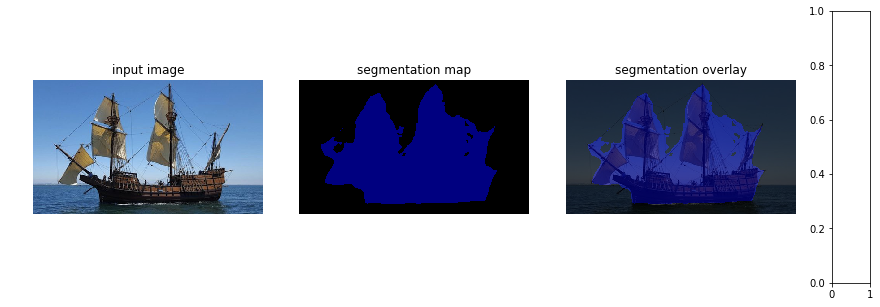

In [11]:
vis_segmentation(resized_im, seg_map)

In [30]:
num_pigs = []
num_objs = []
for ti in range(len(pictures)):
    pic=pictures[ti]
    print(pic)
    difficulty = 80
    jpg = Image.open(join(file_path,pic))
    resized_im, seg_map = MODEL.run(jpg)
    #setting width and length of matrix
    width = len(seg_map[0])
    height = len(seg_map)

    if width > 100:
        interval = math.ceil(width/difficulty)
    if height > 100:
        interval = max(math.ceil(height/difficulty), interval)

    mat = []
    for index,i in enumerate(seg_map):
        tam = []
        if index % interval == 0:
            for index,j in enumerate(i):
                if index % interval == 0:
                    tam.append(1 if j != 0 else 0)
            if tam.count(1)>3:
                mat.append(tam)

    for i in range(4 if len(mat)%2 == 0 else 3):
        mat.insert(0,[0 for i in range(len(mat[0]))])
    for i in mat:
        for count in range(3):
            i.append(0)
            i.insert(0,0)
    for it in range(10):
        obj = OBJmatrix(matrix=mat,name=str(it)+pic.split('.')[0]+'.xml',difficulty = int(difficulty))
        num_pigs.append(obj.num_pigs)
        num_objs.append(obj.num_objs)

rowboat.jpg
Ferry.jpg
test-own-car.png


/home/zzl/.local/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


download.jpeg
Cow.jpg
dog.jpg
people.jpeg
howercraft.jpg
Catamaran.jpg
Cat.jpg
Horse.jpg
Dog.jpg
cat.jpg
downloa.jpeg
Galleon.jpg
Inflatable_Boat.jpg


In [31]:
import numpy as np

In [32]:
np.average(num_objs)

297.49375

In [33]:
np.std(num_objs)

159.81645710294515

In [34]:
np.average(num_pigs)

16.63125

In [35]:
np.std(num_pigs)

10.17756225416971